RNN runs much faster on GPU than CPU due to its computational complexity. The following code is designed to run on Google Colab. To do so, please upload this notebook and 'clean data.csv' to your Google drive. 

The following code is inspired by 'Text classification with an RNN' tutorial, available on TensorFlow website. (https://www.tensorflow.org/text/tutorials/text_classification_rnn#stack_two_or_more_lstm_layers)

In [ ]:
# Import packages
import numpy as np
import pandas as pd

from sklearn.utils import shuffle

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Access to person google drive, where dataset has been stored
# Run the cell and follow the instructions 
from google.colab import drive
drive.mount('/content/drive')

## Prepare Datasets

In [ ]:
# Import full cleaned dataset 
di=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned dataset.csv')
di=di[['full_text', 'created_at']]
di.full_text=[str(i) for i in di.full_text]

In [ ]:
# Create dataset 1 which just has 3 time period
da=di.copy()
da=da[da.created_at.isin(['2021-04', '2020-10', '2020-04'])]

# Create dataset 2 which just has 6 time period.
db=di.copy()
db=db[db.created_at.isin(['2021-04', '2020-10', '2020-04', '2019-10', '2019-04', '2018-10'])]

# Create dataset 3 which just has 9 time period.
dc=di.copy()


In [ ]:
# Create a function to prepare the data set into train and test sets in tensorflow dataset format for RNN
def prep_RNN(df):

  df=shuffle(df)

  # Get one hot encoding of columns B
  one_hot = pd.get_dummies(df['created_at'])
  # Drop column B as it is now encoded
  df = df.drop('created_at',axis = 1)
  df=pd.concat([df, one_hot], axis=1)

  # define the y
  target=df.drop('full_text', axis=1)

  # convert the data set into tensorflow type
  dataset = tf.data.Dataset.from_tensor_slices((df['full_text'].values, target.values))

  # shuffle
  shuffle_buffer_size=int(len(df)*1.2)
  dataset=dataset.shuffle(shuffle_buffer_size)

  # train test split
  train_size=int(len(df)*0.8)
  train_dataset = dataset.take(train_size)
  test_dataset = dataset.skip(train_size)

  # set batch size
  batch_size = 32

  # batch and prefetch to facilitate the following RNN processing 
  train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

In [ ]:
# Prepare the data set
d11, d12=prep_RNN(da)
d21, d22 =prep_RNN(db)
d31, d32 =prep_RNN(dc)

In [ ]:
# Inspect a random sample
for example, label in d32.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'study show reduce pcv vaccine dose safe effective uk first'
 b'discuss importance flu vaccine westminster'
 b'uk theyre go deliberately infect ppl covid name find vaccine wtf pass ethic approval']

labels:  [[0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]]


## Text Encoder

In [ ]:
# Build text encoder and train on dataset1
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
# Make a text-only dataset (without labels), and call adapt
encoder.adapt(d11.map(lambda text, label: text))


In [ ]:
# Build text encoder and train on dataset1
VOCAB_SIZE = 10000
encoder2 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder2.adapt(d21.map(lambda text, label: text))

In [ ]:
# Build text encoder and train on dataset1
VOCAB_SIZE = 10000
encoder3 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder3.adapt(d31.map(lambda text, label: text))


In [ ]:
# Check the most frequent words in dataset1
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'vaccine', 'uk', 'need', 'covid19', 'trial',
       'coronavirus', 'covid', 'say', 'volunteer', 'test', 'infect',
       'healthy', 'people', 'dont', 'u', 'world', 'study', 'full'],
      dtype='<U106')

In [ ]:
# Check the most frequent words in dataset1
vocab = np.array(encoder2.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'vaccine', 'uk', 'flu', 'get', 'need', 'free',
       'first', 'jab', 'people', 'trial', 'child', 'say', 'covid19',
       'world', 'coronavirus', 'gp', 'year', 'covid'], dtype='<U106')

In [ ]:
# Check the most frequent words in dataset1
vocab = np.array(encoder3.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'vaccine', 'flu', 'uk', 'get', 'jab', 'free',
       'people', 'need', 'gp', 'child', 'say', 'protect', 'pharmacist',
       'first', 'hpv', 'trial', 'cancer', 'disease'], dtype='<U106')

## RNN Model

In [ ]:
# Create RNN model for dataset 1
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])

In [ ]:
# Create RNN model for dataset 2
model2= tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder2.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax') 
])

In [ ]:
# Create RNN model for dataset 3
model3= tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder3.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax') 
])

In [ ]:
# Complile model1
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Complile model2
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Complile model3
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Fit model1 with train data in dataset 1


history = model.fit(d11, epochs=20, 
                    validation_data=d12,
                    validation_steps=30)

In [ ]:
# Fit model2 with train data in dataset 2
history2 = model2.fit(d21, epochs=20,
                    validation_data=d22,
                    validation_steps=30)

In [ ]:
# Fit model3 with train data in dataset 3
history3 = model3.fit(d31, epochs=20, 
                    validation_data=d32,
                    validation_steps=30)

In [ ]:
# Test model1(epoch=20) with test data from dataset 1
test_loss, test_acc = model.evaluate(d12)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

12/12 [==============================] - 0s 14ms/step - loss: 0.3931 - accuracy: 0.8889
Test Loss: 0.39310386776924133
Test Accuracy: 0.8888888955116272


In [ ]:
# Test model2(epoch=20) with test data from dataset 2
test_loss, test_acc = model2.evaluate(d22)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

23/23 [==============================] - 0s 18ms/step - loss: 0.1744 - accuracy: 0.8458
Test Loss: 0.1744062900543213
Test Accuracy: 0.8458333611488342


In [ ]:
# Test model3(epoch=20) with test data from dataset 3
test_loss, test_acc = model3.evaluate(d32)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

34/34 [==============================] - 1s 14ms/step - loss: 0.1299 - accuracy: 0.8130
Test Loss: 0.12985555827617645
Test Accuracy: 0.8129629492759705


## Visualisation

In [ ]:
# The graph function for accuracy and loss
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

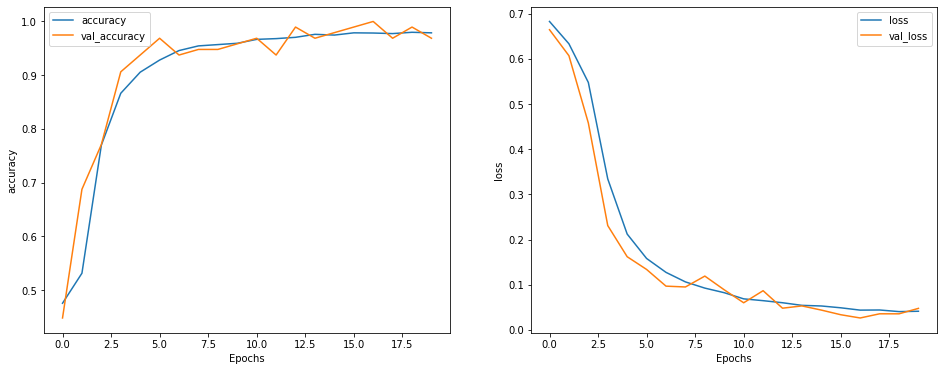

In [ ]:
# Plot data set1

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

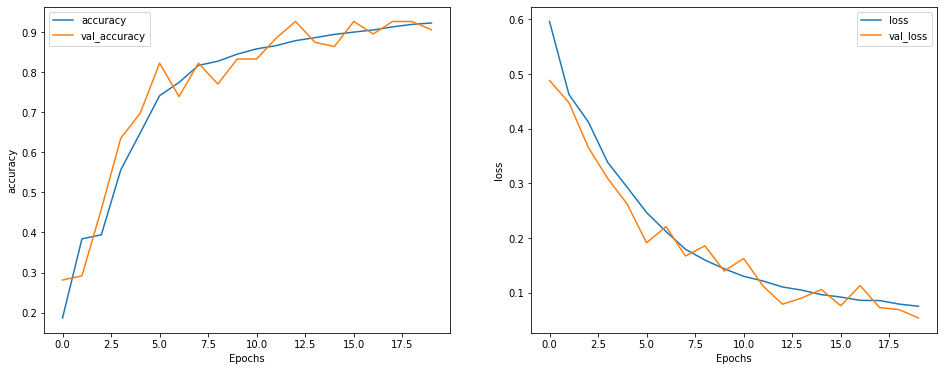

In [ ]:
# Plot data set2
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')

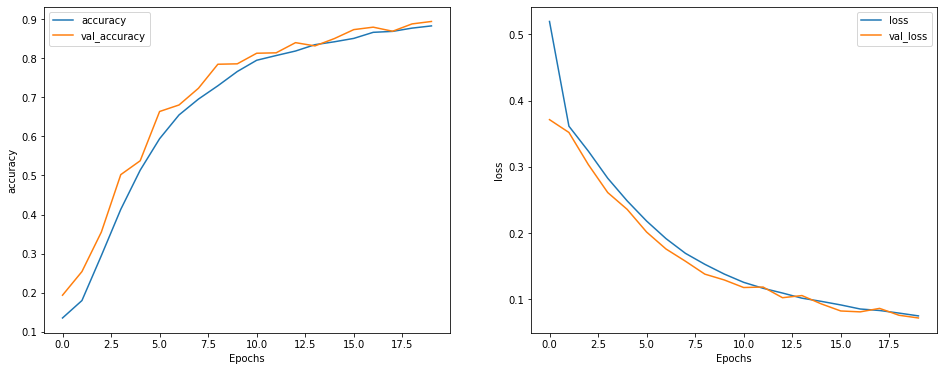

In [ ]:
# Plot data set3
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history3, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history3, 'loss')

Lastly, let's use the model to predict a piece of tweet text that I made myself.  

In [ ]:
# Create a random sentense and make prediction  
sample_text = (['What if I got covid? I need a jab immediately.')
predictions = model3.predict(np.array([sample_text]))
predictions

array([[9.86243308e-01, 9.49914611e-05, 6.65819272e-04, 5.40881278e-03,
        5.68056852e-03, 1.81902433e-03, 1.17695745e-05, 6.09596145e-06,
        6.96353673e-05]], dtype=float32)

In [ ]:
# Transform the result  
predictions=[round(i, 2) for i in predictions[0]]
predictions


[0.99, 0.0, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0]